# __TODO__:
- adapt code to x,y: df[["x", "y"]] = df["location"].apply(pd.Series), df[["x_end", "y_end"]] = df["pass_end_location"].apply(pd.Series)

## __Load Data__

In [ ]:
import pandas as pd
import numpy as np
from statsbombpy import sb
from ast import literal_eval
from dataloader import load_data
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, Standardizer
import math


columns = ['player','location','under_pressure','pass_aerial_won','pass_angle','pass_assisted_shot_id','pass_body_part',
 'pass_cross','pass_cut_back','pass_deflected','pass_end_location','pass_goal_assist','pass_shot_assist','pass_height',
 'pass_inswinging','pass_length','pass_outcome','pass_outswinging','pass_recipient','pass_recipient_id',
 'pass_switch','pass_technique','pass_through_ball','pass_type','shot_key_pass_id']

dtypes = {
    'ball_receipt_outcome': 'category',  # Small set of categorical values
    'ball_recovery_recovery_failure': 'boolean',  # True/False values + NaN
    'block_deflection': 'boolean',  # True/False values + NaN
    'carry_end_location': 'object',  # Lists or complex objects
    'clearance_aerial_won': 'boolean',  # True/False values + NaN
    'clearance_body_part': 'category',  # Categorical values
    'clearance_head': 'boolean',  # True/False values + NaN
    'clearance_left_foot': 'boolean',  # True/False values + NaN
    'clearance_right_foot': 'boolean',  # True/False values + NaN
    'counterpress': 'boolean',  # True/False values + NaN
    'dribble_nutmeg': 'boolean',  # True/False values + NaN
    'dribble_outcome': 'category',  # Categorical values
    'dribble_overrun': 'boolean',  # True/False values + NaN
    'duel_outcome': 'category',  # Categorical values
    'duel_type': 'category',  # Categorical values
    'duration': 'float32',  # Continuous numerical values
    'foul_committed_advantage': 'boolean',  # True/False values + NaN
    'foul_committed_card': 'category',  # Categorical values
    'foul_won_advantage': 'boolean',  # True/False values + NaN
    'foul_won_defensive': 'boolean',  # True/False values + NaN
    'goalkeeper_body_part': 'category',  # Categorical values
    'goalkeeper_end_location': 'object',  # Lists or complex objects
    'goalkeeper_outcome': 'category',  # Categorical values
    'goalkeeper_position': 'category',  # Categorical values
    'goalkeeper_technique': 'category',  # Categorical values
    'goalkeeper_type': 'category',  # Categorical values
    'id': 'string',  # UUIDs, best handled as strings
    'index': 'int32',  # Integers
    'interception_outcome': 'category',  # Categorical values
    'location': 'object',  # Lists or complex objects
    'match_id': 'int32',  # Integers
    'minute': 'int8',  # Small integer range
    'off_camera': 'boolean',  # True/False values + NaN
    'out': 'boolean',  # True/False values + NaN
    'pass_aerial_won': 'boolean',  # True/False values + NaN
    'pass_angle': 'float32',  # Continuous numerical values
    'pass_assisted_shot_id': 'string',  # UUIDs, best handled as strings
    'pass_body_part': 'category',  # Categorical values
    'pass_cross': 'boolean',  # True/False values + NaN
    'pass_cut_back': 'boolean',  # True/False values + NaN
    'pass_deflected': 'boolean',  # True/False values + NaN
    'pass_end_location': 'object',  # Lists or complex objects
    'pass_goal_assist': 'boolean',  # True/False values + NaN
    'pass_height': 'category',  # Categorical values
    'pass_inswinging': 'boolean',  # True/False values + NaN
    'pass_length': 'float32',  # Continuous numerical values
    'pass_outcome': 'category',  # Categorical values
    'pass_outswinging': 'boolean',  # True/False values + NaN
    'pass_shot_assist': 'boolean',  # True/False values + NaN
    'pass_switch': 'boolean',  # True/False values + NaN
    'pass_technique': 'category',  # Categorical values
    'pass_through_ball': 'boolean',  # True/False values + NaN
    'pass_type': 'category',  # Categorical values
    'period': 'int8',  # Only 1 or 2
    'play_pattern': 'category',  # Categorical values
    'position': 'category',  # Categorical values
    'possession': 'int16',  # Medium-sized integer range
    'second': 'int8',  # Small integer range
    'shot_aerial_won': 'boolean',  # True/False values + NaN
    'shot_body_part': 'category',  # Categorical values
    "under_pressure" : "boolean",
    "player" : "string"
}

def load_event_data(match=False):
    if match:
        COMPETITION_ID = 9
        SEASON_ID = 27
        MATCH_ID = 3890561 
        events = sb.events(match_id=MATCH_ID)
        df = events.loc[events["type"] == "Pass", columns] # [row, column] selector
        print(df.shape, df.columns)
        return df
    else:
        df = load_data(frac=(0.1))
        df = df.loc[df["type"] == "Pass", columns] 
        print(df.shape, df.columns)
        return df

MATCH=True
df = load_event_data(match=MATCH)

(1096, 25) Index(['player', 'location', 'under_pressure', 'pass_aerial_won', 'pass_angle',
       'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflected', 'pass_end_location',
       'pass_goal_assist', 'pass_shot_assist', 'pass_height',
       'pass_inswinging', 'pass_length', 'pass_outcome', 'pass_outswinging',
       'pass_recipient', 'pass_recipient_id', 'pass_switch', 'pass_technique',
       'pass_through_ball', 'pass_type', 'shot_key_pass_id'],
      dtype='object')


## __Generate Features__

In [ ]:
PI = math.pi

def convert_to_list(input_data):
    try:
        return literal_eval(input_data)
    except (ValueError, SyntaxError):
        print(f"Error: The string {input_data} could not be converted to a list.")
        return None
    
def is_in_attacking_third(location):
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]

    attacking_third_start = 2 * (pitch_width / 3)
    return (attacking_third_start <= x <= pitch_width)  # Stop before penalty area

def is_in_middle_third(location):
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]

    left_boundary = 1 * (pitch_width/3)
    right_boundary = 2 * (pitch_width/3)
    return (left_boundary <= x < right_boundary)

def is_in_defending_third(location):
    pitch_width = 120
    if isinstance(location, str):
            location = convert_to_list(location)
    x = location[0]

    left_boundary = 1 * (pitch_width/3)
    return (x < left_boundary)

def is_in_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]
    y = location[1]

    # Check if in larger penalty area but NOT in goal area
    x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
    y_axis = ((40 - 22) <= y and y <= (40 + 22))
    return x_axis and y_axis

def is_in_goal_area(location):
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]
    y = location[1]

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

def is_in_edge_of_the_box(location):
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)
        
    x = location[0]
    y = location[1]

    x_axis = ((102 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

def completed_passes(df):
    return (df["pass_outcome"] != "Incomplete") & \
           (df["pass_outcome"] != "Injury Clearance") & \
           (df["pass_outcome"] != "Out") & \
           (df["pass_outcome"] != "Pass Offside") & \
           (df["pass_outcome"] != "Unknown") 

def is_cut_back_into_edge_of_the_box(df):
    return ((df["pass_cut_back"] == True) & (df["pass_end_location"].apply(is_in_edge_of_the_box)))

def is_chip_ball(df):
    return ((df["pass_height"] == "High Pass"))

def is_vertical_pass(angle, max_tolerance=50):
    """
    Checks if the ball's movement is considered to be deep or vertical moving moving along side the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - max_tolerance (float): Maximum angle in degrees .

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle)


def is_horizontal_pass(angle, min_tolerance=75, max_tolerance=105):
    """
    Checks if the ball's movement is primarily horizontal based on the angle between the pass direction and the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - min_tolerance (float): Minimum angle in degrees (default is 75°).
    - max_tolerance (float): Maximum angle in degrees (default is 105°).

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle) >= min_tolerance

def is_progressive_pass(angle, tolerance=75):
    """
    Checks if the ball's movement angle (in radians) is a progressive pass and within the allowed range of angle towards the goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) < tolerance

def is_backward_pass(angle, tolerance=105):
    """
    Checks if the ball's movement angle (in radians) is a defensive pass and within the allowed range of angle towards the own goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) > tolerance


def is_ex_inside_goal_area(location):
    #print("Executing is_in_goal_area method")
    pitch_width = 120
    if isinstance(location, str):
            location = convert_to_list(location)

    x = location[0]
    y = location[1]

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis


def is_ex_inside_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120
    if isinstance(location, str):
        location = convert_to_list(location)
    x = location[0]
    y = location[1]

    if is_ex_inside_goal_area(location):
        return False
    else:
        # Check if in larger penalty area but NOT in goal area
        x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
        y_axis = ((40 - 22) <= y and y <= (40 + 22))
        return x_axis and y_axis

def is_ex_inside_attacking_third(location):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120
    if isinstance(location, str):
        location = convert_to_list(location)
    x = location[0]
    y = location[1]

    if is_ex_inside_goal_area(location) or is_ex_inside_penalty_area(location):
        return False
    else:
        attacking_third_start = 2 * (pitch_width / 3)
        return (attacking_third_start <= x <= pitch_width) 


def calculate_degree(radiant):
    return (radiant * (180/3.14))

def is_pass_completed(pass_outcome):
    return ( (pass_outcome != "Incomplete") & (pass_outcome != "Injury Clearance") & (pass_outcome != "Out") & (pass_outcome != "Pass Offside") &  (pass_outcome != "Unknown") )


df["under_pressure"] = df["under_pressure"] == True

def player_pressure_grouping(df):
    """
    This function Pre-compute all conditions for Vectorize operations.
    Returns results grouped by player and under_pressure  
    """
    # Pre-compute all conditions
    df_with_flags = df.copy()
    
    # Location-based flags
    df_with_flags['is_attacking_third'] = df['location'].apply(is_in_attacking_third)
    df_with_flags['is_middle_third'] = df['location'].apply(is_in_middle_third)
    df_with_flags['is_defending_third'] = df['location'].apply(is_in_defending_third)
    df_with_flags['is_in_box'] = df['location'].apply(is_in_penalty_area)
    df_with_flags['is_in_edge_box'] = df['location'].apply(is_in_edge_of_the_box)
    
    # End location flags
    df_with_flags['end_attacking_third'] = df['pass_end_location'].apply(is_in_attacking_third)
    df_with_flags['end_in_box'] = df['pass_end_location'].apply(is_in_penalty_area)
    df_with_flags['end_in_goal_area'] = df['pass_end_location'].apply(is_in_goal_area)
    df_with_flags['end_in_edge_box'] = df['pass_end_location'].apply(is_in_edge_of_the_box)
    
    # Pass type flags
    df_with_flags['is_completed'] = df['pass_outcome'].isna()
    df_with_flags['is_vertical'] = df['pass_angle'].apply(is_vertical_pass)
    df_with_flags['is_horizontal'] = df['pass_angle'].apply(is_horizontal_pass)
    df_with_flags['is_backward'] = df['pass_angle'].apply(is_backward_pass)
    df_with_flags['is_progressive'] = df['pass_angle'].apply(is_progressive_pass)
    df_with_flags['is_pass_shot_assist'] = df['pass_shot_assist'] == True
    df_with_flags['is_pass_goal_assist'] = df['pass_goal_assist'] == True
    df_with_flags['is_switch'] = df['pass_switch'] == True
    df_with_flags['is_cross'] = df['pass_cross'] == True
    df_with_flags['is_cut_back'] = df['pass_cut_back'] == True
    df_with_flags['is_through_ball'] = df['pass_technique'] == "Through Ball"

    # Pass length categories
    df_with_flags['is_short'] = (df['pass_length'] >= 5) & (df['pass_length'] <= 15)
    df_with_flags['is_medium'] = (df['pass_length'] >= 15) & (df['pass_length'] <= 30)
    df_with_flags['is_long'] = df['pass_length'] >= 30
    df_with_flags['is_short_and_completed'] = (df_with_flags['is_short']) & (df_with_flags['is_completed'])
    df_with_flags['is_medium_and_completed'] = (df_with_flags['is_medium']) & (df_with_flags['is_completed'])
    df_with_flags['is_long_and_completed'] = (df_with_flags['is_long']) & (df_with_flags['is_completed'])
    df_with_flags['is_progressive_and_completed'] = (df_with_flags['is_progressive']) & (df_with_flags['is_completed'])
    df_with_flags['is_horizontal_and_completed'] = (df_with_flags['is_horizontal']) & (df_with_flags['is_completed'])
    df_with_flags['is_backward_and_completed'] = (df_with_flags['is_backward']) & (df_with_flags['is_completed'])
    df_with_flags['is_long_and_vertical'] = (df_with_flags['is_long']) & (df_with_flags['is_vertical'])
    df_with_flags['is_long_vertical_and_from_defending_third'] = (df_with_flags['is_long']) & (df_with_flags['is_vertical']) 
    df_with_flags['is_long_vertical_and_from_mid_third'] = (df_with_flags['is_long']) & (df_with_flags['is_vertical']) & (df_with_flags['is_middle_third'])
    df_with_flags['is_long_vertical_and_from_mid_third_into_the_box'] = (df_with_flags['is_long']) & (df_with_flags['is_vertical']) & (df_with_flags['is_middle_third']) & (df_with_flags['end_in_box'])
    
    # Combined conditions
    df_with_flags['into_box_not_from_box'] = df_with_flags['end_in_box'] & ~df_with_flags['is_in_box']
    df_with_flags['into_box_not_from_box_completed'] = df_with_flags['into_box_not_from_box'] & df_with_flags['is_completed']
    df_with_flags['into_edge_box_not_from_edge_box'] = df_with_flags['end_in_edge_box'] & ~df_with_flags['is_in_edge_box']
    df_with_flags['into_edge_box_not_from_edge_box_completed'] = df_with_flags['into_edge_box_not_from_edge_box'] & df_with_flags['is_completed']
    df_with_flags['is_through_ball_and_completed'] = (df_with_flags['is_through_ball']) & (df_with_flags['is_completed'])
    
    df_with_flags['within_attacking_third'] = df_with_flags['is_attacking_third'] & df_with_flags['end_attacking_third']
    df_with_flags['within_attacking_third_completed'] = df_with_flags['within_attacking_third'] & df_with_flags['is_completed']
    
    # Pass type combinations
    df_with_flags['vertical_into_edge'] = (df_with_flags['is_vertical'] & 
                                          df_with_flags['end_in_edge_box'] & 
                                          (df['pass_type'] != "Corner") &
                                          ~df_with_flags['is_in_edge_box'])
    
    df_with_flags['vertical_into_box'] = (df_with_flags['is_vertical'] & 
                                         df_with_flags['end_in_box'] & 
                                         (df['pass_type'] != "Corner") &
                                         ~df_with_flags['is_in_box'])
    
    df_with_flags['horizontal_into_box'] = (df_with_flags['is_horizontal'] & 
                                           df_with_flags['end_in_box'] & 
                                           (df['pass_type'] != "Corner") &
                                           ~df_with_flags['is_in_box'])
    
    df_with_flags['horizontal_into_edge'] = (df_with_flags['is_horizontal'] & 
                                            df_with_flags['end_in_edge_box'] & 
                                            (df['pass_type'] != "Corner") &
                                            ~df_with_flags['is_in_edge_box'])
    
    # More specialized combinations
    df_with_flags['cut_back_into_edge'] = (df_with_flags['pass_cut_back'] == True) & (df_with_flags["end_in_edge_box"])
    
    df_with_flags['high_vertical_into_edge'] = ((df['pass_height'] == "High Pass") & df_with_flags['vertical_into_edge'])
    df_with_flags['high_vertical_into_box'] = ((df['pass_height'] == "High Pass") & df_with_flags['vertical_into_box'])
    df_with_flags['low_vertical_into_edge'] = ((df['pass_height'] == "Ground Pass") & df_with_flags['vertical_into_edge'])
    df_with_flags['low_vertical_into_box'] = ((df['pass_height'] == "Ground Pass") & df_with_flags['vertical_into_box'])

    df_with_flags['high_horizontal_into_edge'] = ((df['pass_height'] == "High Pass") & df_with_flags['horizontal_into_edge'])
    df_with_flags['high_horizontal_into_box'] = ((df['pass_height'] == "High Pass") & df_with_flags['horizontal_into_box'])
    df_with_flags['low_horizontal_into_edge'] = ((df['pass_height'] == "Ground Pass") & df_with_flags['horizontal_into_edge'])
    df_with_flags['low_horizontal_into_box'] = ((df['pass_height'] == "Ground Pass") & df_with_flags['horizontal_into_box'])
    
    
    result = df_with_flags.groupby(['player', 'under_pressure']).agg(
        passes_total=('player', 'count'),
        passes_completed=('is_completed', 'sum'),
        passes_from_attacking_third=('is_attacking_third', 'sum'),
        passes_from_middle_third=('is_middle_third', 'sum'),
        passes_from_defending_third=('is_defending_third', 'sum'),
        passes_from_the_box=('is_in_box', 'sum'),
        passes_into_attacking_third=('end_attacking_third', 'sum'),
        passes_into_box=('into_box_not_from_box', 'sum'),
        passes_into_box_completed=('into_box_not_from_box_completed', 'sum'),
        passes_into_goal_area=("end_in_goal_area", "sum"),
        passes_into_edge_of_the_box=("into_edge_box_not_from_edge_box", "sum"),
        passes_into_edge_of_the_box_completed=("into_edge_box_not_from_edge_box", "sum"),
        passes_cuts_last_line_of_defence=("is_through_ball", "sum"),
        passes_cuts_last_line_of_defence_completed=("is_through_ball_and_completed", "sum"),
        passes_within_attacking_third=("within_attacking_third", "sum"),
        passes_within_attacking_third_completed=("within_attacking_third_completed", "sum"),
        passes_total_distance=("pass_length", "sum"),
        passes_short_total=("is_short", "sum"),
        passes_short_completed=("is_short_and_completed", "sum"),
        passes_medium_total=("is_medium", "sum"),
        passes_medium_completed=("is_medium_and_completed", "sum"),
        passes_long_total=("is_long", "sum"),
        passes_long_completed=("is_long_and_completed", "sum"),
        passes_shot_assist=("is_pass_shot_assist", "sum"),
        passes_goal_assist=("is_pass_goal_assist", "sum"),
        passes_switch=("is_switch", "sum"),
        passes_cross=("is_cross", "sum"),
        passes_cut_back=("is_cut_back", "sum"),
        passes_vertical_into_edge_of_the_box=("vertical_into_edge", "sum"),
        passes_vertical_into_the_box=("vertical_into_box", "sum"),
        passes_horizontal_into_edge_of_the_box=("horizontal_into_edge", "sum"),
        passes_horizontal_into_the_box=("horizontal_into_box", "sum"),
        passes_cut_back_into_edge_of_the_box=("cut_back_into_edge", "sum"),
        passes_high_vertical_into_edge_of_the_box=("high_vertical_into_edge", "sum"),
        passes_high_vertical_into_the_box=("high_vertical_into_box", "sum"),
        passes_low_vertical_into_edge_of_the_box=("low_vertical_into_edge", "sum"),
        passes_low_vertical_into_the_box=("low_vertical_into_box", "sum"),
        passes_high_horizontal_into_edge_of_the_box=("high_horizontal_into_edge", "sum"),
        passes_high_horizontal_into_the_box=("high_horizontal_into_box", "sum"),
        passes_low_horizontal_into_edge_of_the_box=("low_horizontal_into_edge", "sum"),
        passes_low_horizontal_into_the_box=("low_horizontal_into_box", "sum"),
        passes_progressive=("is_progressive", "sum"),
        passes_progressive_completed=("is_progressive_and_completed", "sum"),
        passes_horizontal=("is_horizontal_and_completed", "sum"),
        passes_horizontal_completed=("is_horizontal_and_completed", "sum"),
        passes_backward=("is_backward", "sum"),
        passes_backward_completed=("is_backward_and_completed", "sum"),
        passes_long_vertical=("is_long_and_vertical", "sum"),
        passes_long_vertical_from_defending_third=("is_long_vertical_and_from_defending_third", "sum"),
        passes_long_vertical_from_mid_third=("is_long_vertical_and_from_mid_third", "sum"),
        passes_long_vertical_from_mid_third_into_the_box=("is_long_vertical_and_from_mid_third_into_the_box", "sum"),
    )
    
    return result

player_under_pressure_grouping = player_pressure_grouping(df)

player_under_pressure_grouping["key_passes"] = player_under_pressure_grouping['passes_shot_assist'] + player_under_pressure_grouping['passes_goal_assist']
player_under_pressure_grouping


passes_total  passes_completed  \
player                        under_pressure                                   
Alessandro Schöpf             False                     10                 9   
                              True                       3                 1   
Andrej Kramarić               False                     25                20   
                              True                      11                 5   
Benedikt Höwedes              False                     50                46   
                              True                       4                 3   
Ermin Bičakčić                False                     47                45   
                              True                       5                 2   
Eugen Polanski                False                     14                14   
                              True                       4                 4   
Fabian Lukas Schär            False                     56                49   
                              True                      16                15   
Jean-Eric Maxim Choupo-Moting False                     25                21   
                              True                       9                 7   
Jens Grahl                    False                     25                20   
Johannes Geis                 False                     74                68   
                              True                      12                 9   
Joël Andre Job Matip          False                     74                70   
                              True                       4                 4   
Kevin Kuranyi                 False                      6                 5   
                              True                       1                 0   
Kevin Volland                 False                     21                10   
                              True                       9                 2   
Klaas-Jan Huntelaar           False                     18                16   
                              True                       6                 5   
Leroy Sané                    False                     27                24   
                              True                       6                 4   
Marco Höger                   False                      3                 3   
Mark Uth                      False                      9                 7   
                              True                      10                 7   
Max Meyer                     False                     32                29   
                              True                      12                 8   
Nadiem Amiri                  False                     13                11   
                              True                       1                 1   
Pavel Kadeřábek               False                     27                22   
                              True                      12                10   
Pirmin Schwegler              False                     23                23   
                              True                      12                11   
Ralf Fährmann                 False                     46                35   
                              True                       2                 1   
Roman Neustädter              False                     48                46   
                              True                       6                 5   
Sead Kolašinac                False                     50                47   
                              True                       8                 4   
Sebastian Rudy                False                     41                35   
                              True                      11                 9   
Tarik Elyounoussi             False                     44                41   
                              True                      16                10   
Tobias Strobl                 False           

In [35]:
total_stats = player_under_pressure_grouping.groupby('player').sum()
player_under_pressure_grouping = player_under_pressure_grouping.add_prefix('up_')
player_under_pressure_grouping = player_under_pressure_grouping.reset_index()
player_under_pressure_grouping = player_under_pressure_grouping[player_under_pressure_grouping["under_pressure"] == True]
player_under_pressure_grouping = player_under_pressure_grouping.drop("under_pressure", axis=1)

player_stats = pd.merge(left=total_stats, right=player_under_pressure_grouping, on="player")
display(player_stats), print(player_stats.columns)

,player,passes_total,passes_completed,passes_from_attacking_third,passes_from_middle_third,passes_from_defending_third,passes_from_the_box,passes_into_attacking_third,passes_into_box,passes_into_box_completed,...,up_passes_progressive_completed,up_passes_horizontal,up_passes_horizontal_completed,up_passes_backward,up_passes_backward_completed,up_passes_long_vertical,up_passes_long_vertical_from_defending_third,up_passes_long_vertical_from_mid_third,up_passes_long_vertical_from_mid_third_into_the_box,up_key_passes
0,Alessandro Schöpf,13,10,7,2,4,1,5,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Andrej Kramarić,36,25,17,16,3,4,18,4,2,...,1,1,1,4,3,0,0,0,0,0
2,Benedikt Höwedes,54,49,6,31,17,0,10,2,1,...,2,0,0,1,1,1,1,0,0,0
3,Ermin Bičakčić,52,47,1,21,30,0,2,1,0,...,2,0,0,0,0,1,1,0,0,0
4,Eugen Polanski,18,18,4,11,3,0,6,0,0,...,3,0,0,1,1,0,0,0,0,0
5,Fabian Lukas Schär,72,64,1,43,28,0,11,1,1,...,12,1,1,2,2,1,1,1,0,0
6,Jean-Eric Maxim Choupo-Moting,34,28,10,23,1,2,14,0,0,...,4,0,0,3,3,0,0,0,0,0
7,Johannes Geis,86,77,5,48,33,0,15,5,1,...,5,1,1,3,3,1,1,0,0,0
8,Joël Andre Job Matip,78,74,0,19,59,0,1,0,0,...,1,2,2,1,1,0,0,0,0,0
9,Kevin Kuranyi,7,5,3,4,0,1,4,0,0,...,0,0,0,0,0,0,0,0,0,0


Index(['player', 'passes_total', 'passes_completed',
       'passes_from_attacking_third', 'passes_from_middle_third',
       'passes_from_defending_third', 'passes_from_the_box',
       'passes_into_attacking_third', 'passes_into_box',
       'passes_into_box_completed',
       ...
       'up_passes_progressive_completed', 'up_passes_horizontal',
       'up_passes_horizontal_completed', 'up_passes_backward',
       'up_passes_backward_completed', 'up_passes_long_vertical',
       'up_passes_long_vertical_from_defending_third',
       'up_passes_long_vertical_from_mid_third',
       'up_passes_long_vertical_from_mid_third_into_the_box', 'up_key_passes'],
      dtype='object', length=105)


(None, None)

## __Creation of Relative Values__

In [44]:
calculation_pairs = [
        ('passes_completed', 'passes_total', "pass_accuracy"),
        ('up_passes_completed', 'up_passes_total', "up_pass_accuracy"),
        ("passes_progressive_completed", "passes_progressive","pass_accuracy_progressive"),
        ("up_passes_progressive_completed", "up_passes_progressive","up_pass_accuracy_progressive"),
        ("passes_backward_completed", "passes_backward","pass_accuracy_backward"),
        ("passes_horizontal_completed", "passes_horizontal","pass_horizontal_backward"),
        ("up_passes_backward_completed", "up_passes_backward","up_pass_accuracy_backward"),
        ("passes_into_box_completed", "passes_into_box", "pass_accuracy_into_box"),
        ("passes_into_box_completed", "passes_into_box", "pass_accuracy_into_box"),
        # TODO: passes_into_edge_of_the_box_completed
        ("up_passes_into_box_completed", "up_passes_into_box", "up_pass_accuracy_into_box"),
        ("passes_short_completed" , "passes_short_total", "pass_accuaracy_short"),
        ("passes_medium_completed" , "passes_medium_total", "pass_accuaracy_medium"),
        ("passes_long_completed" , "passes_long_total", "pass_accuaracy_long"),
        ("passes_within_attacking_third_completed","passes_within_attacking_third", "pass_accuracy_within_attacking_third"),       
        ("up_passes_within_attacking_third_completed","up_passes_within_attacking_third", "up_pass_accuracy_within_attacking_third"),   
        ("passes_shot_assist", "passes_progressive", "pass_progressive_lead_to_shot_%" ),
        ("passes_goal_assist", "passes_progressive", "pass_progressive_lead_to_goal_%" ),
        ("passes_total_distance", "passes_total", "pass_mean_distance"),
        ("passes_cuts_last_line_of_defence","passes_cuts_last_line_of_defence_completed", "pass_accuracy_cuts_last_line_of_defence")
        
    ]
    
only_for_printing = ["player",'passes_completed']
calculated_cols=[]

for a, b, c in calculation_pairs:
    player_stats[c] = (player_stats[f'{a}'] / player_stats[f'{b}']).round(3)
    only_for_printing.append(c)
    calculated_cols.append(c)
    
player_stats[only_for_printing]

,player,passes_completed,pass_accuracy,up_pass_accuracy,pass_accuracy_progressive,up_pass_accuracy_progressive,pass_accuracy_backward,pass_horizontal_backward,up_pass_accuracy_backward,pass_accuracy_into_box,...,up_pass_accuracy_into_box,pass_accuaracy_short,pass_accuaracy_medium,pass_accuaracy_long,pass_accuracy_within_attacking_third,up_pass_accuracy_within_attacking_third,pass_progressive_lead_to_shot_%,pass_progressive_lead_to_goal_%,pass_mean_distance,pass_accuracy_cuts_last_line_of_defence
0,Alessandro Schöpf,10,0.769,0.333,0.571,0.333,1.000,1.0,NaN,NaN,...,NaN,0.833,0.500,1.000,0.600,0.0,0.000,0.000,18.919,NaN
1,Andrej Kramarić,25,0.694,0.455,0.417,0.250,0.929,1.0,0.750,0.500,...,NaN,0.769,0.846,0.600,0.529,0.4,0.000,0.000,16.284,NaN
2,Benedikt Höwedes,49,0.907,0.750,0.871,0.667,1.000,1.0,1.000,0.500,...,NaN,1.000,0.885,0.778,0.833,NaN,0.065,0.000,20.460,NaN
3,Ermin Bičakčić,47,0.904,0.400,0.872,0.400,1.000,1.0,NaN,0.000,...,NaN,1.000,0.967,0.700,1.000,NaN,0.000,0.000,21.901,NaN
4,Eugen Polanski,18,1.000,1.000,1.000,1.000,1.000,1.0,1.000,NaN,...,NaN,1.000,1.000,1.000,1.000,NaN,0.077,0.000,20.626,NaN
5,Fabian Lukas Schär,64,0.889,0.938,0.849,0.923,1.000,1.0,1.000,1.000,...,NaN,0.889,0.950,0.714,1.000,NaN,0.000,0.000,24.566,NaN
6,Jean-Eric Maxim Choupo-Moting,28,0.824,0.778,0.769,0.800,1.000,1.0,1.000,NaN,...,NaN,0.938,0.786,0.667,0.600,0.0,0.077,0.000,16.270,NaN
7,Johannes Geis,77,0.895,0.750,0.860,0.714,1.000,1.0,1.000,0.200,...,0.0,0.944,1.000,0.684,0.200,0.0,0.023,0.000,20.604,NaN
8,Joël Andre Job Matip,74,0.949,1.000,0.909,1.000,1.000,1.0,1.000,NaN,...,NaN,0.957,0.977,0.833,NaN,NaN,0.000,0.023,22.161,1.0
9,Kevin Kuranyi,5,0.714,0.000,1.000,NaN,0.667,1.0,NaN,NaN,...,NaN,1.000,1.000,0.000,0.333,0.0,0.000,0.000,14.831,NaN


### __All features__

In [84]:
player_stats.shape, player_stats.columns

((25, 115),
 Index(['player', 'passes_total', 'passes_completed',
        'passes_from_attacking_third', 'passes_from_middle_third',
        'passes_from_defending_third', 'passes_from_the_box',
        'passes_into_attacking_third', 'passes_into_box',
        'passes_into_box_completed',
        ...
        'pass_accuracy_into_box', 'pass_accuaracy_short',
        'pass_accuaracy_medium', 'pass_accuaracy_long',
        'pass_accuracy_within_attacking_third',
        'pass_progressive_lead_to_shot_%', 'pass_progressive_lead_to_goal_%',
        'pass_mean_distance', 'up_pass_accuracy_within_attacking_third',
        'up_pass_accuracy_into_box'],
       dtype='object', length=115))

## __Feature Selection__

In [46]:
columns_to_keep = ['player','pass_accuracy',
 'up_pass_accuracy',
 'pass_accuracy_progressive',
 'up_pass_accuracy_progressive',
 'pass_accuracy_backward',
 'pass_horizontal_backward',
 'up_pass_accuracy_backward',
 'pass_accuracy_into_box',
 'pass_accuracy_into_box',
 'up_pass_accuracy_into_box',
 'pass_accuaracy_short',
 'pass_accuaracy_medium',
 'pass_accuaracy_long',
 'pass_accuracy_within_attacking_third',
 'up_pass_accuracy_within_attacking_third',
 'pass_progressive_lead_to_shot_%',
 'pass_progressive_lead_to_goal_%',
 'pass_mean_distance',
 'pass_accuracy_cuts_last_line_of_defence',
                'passes_from_attacking_third', 'passes_from_middle_third',
                'passes_from_defending_third', 'passes_from_the_box',
                'passes_into_attacking_third', 'passes_into_box',
                'passes_into_box_completed', 'passes_into_goal_area',
                'passes_into_edge_of_the_box', 'passes_within_attacking_third',
                'passes_within_attacking_third_completed', 'passes_total_distance',
                'passes_short_total', 'passes_short_completed',
                'passes_medium_completed', 'passes_medium_total', 'passes_long_total',
                'passes_long_completed', 'passes_shot_assist', 'passes_goal_assist',
                'passes_switch', 'passes_cross', 'passes_cut_back',
                'passes_vertical_into_edge_of_the_box', 'passes_vertical_into_the_box',
                'passes_horizontal_into_the_box',
                'passes_horizontal_into_edge_of_the_box',
                'passes_cut_back_into_edge_of_the_box',
                'passes_high_vertical_into_edge_of_the_box',
                'passes_high_vertical_into_the_box',
                'passes_low_vertical_into_edge_of_the_box',
                'passes_low_vertical_into_the_box',
                'passes_high_horizontal_into_the_box',
                'passes_high_horizontal_into_edge_of_the_box',
                'passes_low_horizontal_into_the_box',
                'passes_low_horizontal_into_edge_of_the_box',
                'passes_progressive', 'passes_progressive_completed',
                'passes_horizontal', 'passes_backward', 'passes_backward_completed',
                'passes_long_vertical', 'passes_long_vertical_from_defending_third',
                'passes_long_vertical_from_mid_third',
                'passes_long_vertical_from_mid_third_into_the_box', 'key_passes',
        ]

player_stats[columns_to_keep]

,player,pass_accuracy,up_pass_accuracy,pass_accuracy_progressive,up_pass_accuracy_progressive,pass_accuracy_backward,pass_horizontal_backward,up_pass_accuracy_backward,pass_accuracy_into_box,pass_accuracy_into_box,...,passes_progressive,passes_progressive_completed,passes_horizontal,passes_backward,passes_backward_completed,passes_long_vertical,passes_long_vertical_from_defending_third,passes_long_vertical_from_mid_third,passes_long_vertical_from_mid_third_into_the_box,key_passes
0,Alessandro Schöpf,0.769,0.333,0.571,0.333,1.000,1.0,NaN,NaN,NaN,...,7,4,3,3,3,1,1,0,0,0
1,Andrej Kramarić,0.694,0.455,0.417,0.250,0.929,1.0,0.750,0.500,0.500,...,12,5,7,14,13,0,0,0,0,0
2,Benedikt Höwedes,0.907,0.750,0.871,0.667,1.000,1.0,1.000,0.500,0.500,...,31,27,7,15,15,2,2,0,0,2
3,Ermin Bičakčić,0.904,0.400,0.872,0.400,1.000,1.0,NaN,0.000,0.000,...,39,34,11,2,2,2,2,1,1,0
4,Eugen Polanski,1.000,1.000,1.000,1.000,1.000,1.0,1.000,NaN,NaN,...,13,13,3,2,2,0,0,0,0,1
5,Fabian Lukas Schär,0.889,0.938,0.849,0.923,1.000,1.0,1.000,1.000,1.000,...,53,45,11,8,8,8,8,7,1,0
6,Jean-Eric Maxim Choupo-Moting,0.824,0.778,0.769,0.800,1.000,1.0,1.000,NaN,NaN,...,13,10,3,15,15,2,2,2,0,1
7,Johannes Geis,0.895,0.750,0.860,0.714,1.000,1.0,1.000,0.200,0.200,...,43,37,16,24,24,9,9,5,0,1
8,Joël Andre Job Matip,0.949,1.000,0.909,1.000,1.000,1.0,1.000,NaN,NaN,...,44,40,21,13,13,5,5,1,0,1
9,Kevin Kuranyi,0.714,0.000,1.000,NaN,0.667,1.0,NaN,NaN,NaN,...,2,2,1,3,2,0,0,0,0,0


## __Visualize Passes__

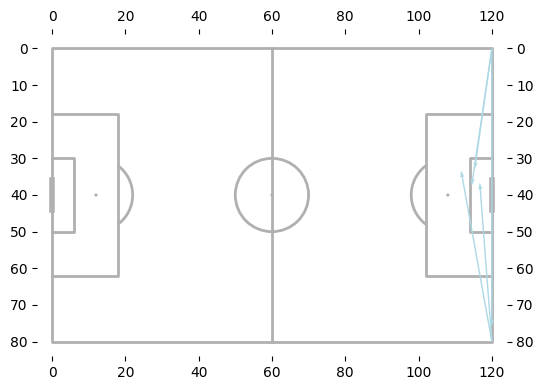

In [30]:
import math
PI = math.pi

def calculate_degree(radiant):
    return (radiant * (180/3.14))

df["degree"] = df["pass_angle"].apply(calculate_degree)

def is_in_attacking_third(location):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    attacking_third_start = 2 * (pitch_width / 3)
    return (attacking_third_start <= x <= pitch_width)  # Stop before penalty area

def is_in_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    # Check if in larger penalty area but NOT in goal area
    x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
    y_axis = ((40 - 22) <= y and y <= (40 + 22))
    return x_axis and y_axis

def is_ball_moving_toward_opponent_goal(angle, tolerance=90):
    """
    Checks if the ball's movement angle (in radians) is within the allowed range of angle towards the goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) < tolerance

def is_ball_moving_vertical(angle, max_tolerance=40):
    """
    Checks if the ball's movement is considered to be deep or vertical moving moving along side the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - max_tolerance (float): Maximum angle in degrees .

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle)

def is_horizontal_pass(angle, min_tolerance=75, max_tolerance=105):
    """
    Checks if the ball's movement is primarily horizontal based on the angle between the pass direction and the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - min_tolerance (float): Minimum angle in degrees (default is 75°).
    - max_tolerance (float): Maximum angle in degrees (default is 105°).

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle) >= min_tolerance

def is_progressive_pass(angle, tolerance=75):
    """
    Checks if the ball's movement angle (in radians) is a progressive pass and within the allowed range of angle towards the goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) < tolerance

def is_backward_pass(angle, tolerance=105):
    """
    Checks if the ball's movement angle (in radians) is a defensive pass and within the allowed range of angle towards the own goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) > tolerance


def is_ex_inside_goal_area(location):
    #print("Executing is_in_goal_area method")
    pitch_width = 120
    x = location[0]
    y = location[1]

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis


def is_ex_inside_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    if is_ex_inside_goal_area(location):
        return False
    else:
        # Check if in larger penalty area but NOT in goal area
        x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
        y_axis = ((40 - 22) <= y and y <= (40 + 22))
        return x_axis and y_axis

def is_ex_inside_attacking_third(location):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    if is_ex_inside_goal_area(location) or is_ex_inside_penalty_area(location):
        return False
    else:
        attacking_third_start = 2 * (pitch_width / 3)
        return (attacking_third_start <= x <= pitch_width)  # Stop before penalty area


def is_in_edge_of_the_box(location):
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]
    y = location[1]

    x_axis = ((102 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

def convert_to_list(input_data):
    try:
        return literal_eval(input_data)
    except (ValueError, SyntaxError):
        print(f"Error: The string {input_data} could not be converted to a list.")
        return None

# GCA, SCA - passes into penalty area (except corners)
"""
passing = df[df["location"].apply(is_ex_inside_attacking_third) & (df["pass_end_location"].apply(is_in_penalty_area))
             & (df["pass_type"] != "Corner")]


# GCA - low horizontal passes into penalty area (except corners)

passing = df.loc[df["pass_angle"].apply(is_horizontal_pass) & (df["location"].apply(is_ex_inside_attacking_third)) 
                 & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                 & (df["pass_height"] == "Ground Pass"), :]


# GCA - low vertical passes into penalty area (except corners)


passing = df.loc[(( df["degree"] >= (-50) )  & (df["degree"] <= (50)) & 
              (df["location"].apply(is_ex_inside_attacking_third)) 
              & (df["pass_end_location"].apply(is_in_penalty_area))) & (df["pass_height"] == "Ground Pass"), :]



# GCA - deep (long) low vertical pass from middle third into penalty area   (except corners)
passing = df.loc[(( df["degree"] >= (-50) )  & (df["degree"] <= (50)) & 
              (df["location"].apply(is_in_middle_third)) 
              & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_length"] >= 30))
              & (df["pass_height"] == "Ground Pass"), :]



# GCA - deep (long) low vertical pass from mid third   
passing = df.loc[(( df["degree"] >= (-40) ) & (df["degree"] <= (40)) & 
              (df["location"].apply(is_in_middle_third)) & (df["pass_length"] >= 30))
              & (df["pass_height"] == "Ground Pass"), :]


# GCA - deep (long) low vertical pass from defending third
passing = df.loc[(( df["degree"] >= (-40) ) & (df["degree"] <= (40)) & (df["pass_length"] >= 30))
                 & (df["location"].apply(is_in_defending_third)) 
              & (df["pass_height"] == "Ground Pass"), :]


# GCA - deep (long) low vertical pass
passing = df.loc[(( df["degree"] >= (-40) ) & (df["degree"] <= (40)) & (df["pass_length"] >= 30)) 
                 & (df["pass_height"] == "Ground Pass"), :]


# GCA - flanke/high/chip horizontal passes into penalty area (except corners) 
passing = df.loc[ (df["pass_angle"].apply(is_horizontal_pass))  & (df["location"].apply(is_ex_inside_attacking_third)) 
                 & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                 & (df["pass_height"] == "High Pass"), :]


# GCA - high chip vertical passes into penalty area (except corners) # (( df["degree"] >= (-50) )  & (df["degree"] <= (50)))
passing = df.loc[ (df["pass_angle"].apply(is_ball_moving_vertical))  & (df["location"].apply(is_ex_inside_attacking_third)) 
                 & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                 & (df["pass_height"] == "High Pass"), :]

# GCA, SCA - flat Backward Pass into danger zone (except corner)
passing = df.loc[(df["location"].apply(is_ex_inside_attacking_third)) & (df["pass_angle"].apply(is_backward_pass)) 
                 & (df["location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner") & (df["pass_height"] == "Ground Pass") , :]

# GCA, SCA - general Backward Pass into danger zone (except corner)
passing = df.loc[(df["location"].apply(is_ex_inside_attacking_third)) & (df["pass_angle"].apply(is_backward_pass)) 
                 & (df["location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner"), :]

# defensive pass                 
passing = df.loc[(df["pass_angle"].apply(is_backward_pass)) &  ~(df["location"].apply(is_in_attacking_third)) 
& (df["pass_type"] != "Corner"), :]

# low vertical passes into danger zone
passing = df.loc[(df["pass_angle"].apply(is_ball_moving_vertical)) &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) 
& (df["pass_type"] != "Corner")  & (df["pass_height"] == "Ground Pass"), :]


# high chip vertical passes into danger zone
passing = df.loc[(df["pass_angle"].apply(is_ball_moving_vertical)) &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) 
& (df["pass_type"] != "Corner")  & (df["pass_height"] == "High Pass"), :]


# cut_back_into_edge_of_the_box 
passing = df.loc[(df["pass_cut_back"] == True) & (df["pass_end_location"].apply(is_in_edge_of_the_box)), :] # (df["pass_cut_back"] == True) 

# GCA - pass that cuts last line of defence completed
passing = df.loc[ (df["pass_technique"] == "Through Ball") &  df["pass_outcome"].apply(is_pass_completed) , :]

"""

# GCA - deep (long) low vertical pass from middle third into penalty area   (except corners)
passing = df.loc[ (df["pass_technique"] == "Inswinging") , :]

if MATCH:
    start_location = np.vstack([passes for passes in passing["location"]])
    end_location = np.vstack([passes for passes in passing["pass_end_location"]])

else:
    start_location = np.vstack([literal_eval(passes) for passes in passing["location"]])
    end_location = np.vstack([literal_eval(passes) for passes in passing["pass_end_location"]])

# Calculate the change in x and y (vector direction)
dx = end_location[:, 0] - start_location[:, 0]  # difference in x (end_x - start_x)
dy = end_location[:, 1] - start_location[:, 1]  # difference in y (end_y - start_y)

# Draw pitch
pitch = Pitch(label=True, tick=True)
fig, ax = pitch.draw(figsize=(8, 4))

# Plot arrows using ax.quiver (from start_location to end_location)

pitch.arrows(start_location[:, 0], start_location[:, 1], end_location[:, 0], end_location[:, 1]
             ,ax=ax, width=1, zorder=2,color='lightblue')
"""ax.quiver(
    start_location[:, 0], start_location[:, 1],  # starting points (x, y)
    dx, dy,  # vector components (dx, dy)
    color='lightblue', scale_units='xy', angles='xy', scale=1, width=0.003, headlength=5, headwidth=5, zorder=5
)"""

plt.show()

In [14]:
passing = df.loc[ df["pass_cross"] == True , :]
passing

,player,location,under_pressure,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,...,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_switch,pass_technique,pass_through_ball,pass_type,shot_key_pass_id,degree
1059709,Henrikh Mkhitaryan,"[113.8, 59.4]",False,NaN,-1.445089,NaN,Right Foot,True,NaN,NaN,...,Incomplete,NaN,Pierre-Emerick Aubameyang,3712.0,NaN,NaN,NaN,NaN,NaN,-82.839503
107690,Hiroshi Kiyotake,"[100.9, 12.5]",False,NaN,1.270723,NaN,Right Foot,True,NaN,NaN,...,NaN,NaN,Artur Sobiech,11845.0,NaN,NaN,NaN,NaN,NaN,72.843971
1024815,Ivan Perišić,"[118.6, 58.6]",False,NaN,-1.757160,c748cba1-6571-47a0-b46c-2c1daa00c257,Right Foot,True,NaN,NaN,...,NaN,NaN,Max Kruse,8386.0,NaN,NaN,NaN,NaN,NaN,-100.728946
25124,Matthias Ostrzolek,"[91.8, 12.1]",False,NaN,1.123496,NaN,Left Foot,True,NaN,NaN,...,Incomplete,NaN,Pierre-Michel Lasogga,8895.0,NaN,NaN,NaN,NaN,NaN,64.404229
46694,Valentin Stocker,"[110.5, 76.2]",False,NaN,-1.710100,NaN,Right Foot,True,NaN,NaN,...,Out,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,-98.031199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269995,Marc Stendera,"[108.3, 71.4]",False,NaN,-1.515060,NaN,Right Foot,True,NaN,NaN,...,Incomplete,NaN,Stefan Aigner,21156.0,NaN,NaN,NaN,NaN,NaN,-86.850579
803094,Johan Danon Djourou-Gbadjere,"[105.3, 74.1]",False,NaN,-1.443645,NaN,Right Foot,True,NaN,NaN,...,Incomplete,NaN,Pierre-Michel Lasogga,8895.0,NaN,NaN,NaN,NaN,NaN,-82.756725
799276,Marcel Risse,"[102.1, 64.2]",False,NaN,-1.088611,NaN,Right Foot,True,NaN,NaN,...,Out,NaN,Anthony Modeste,23486.0,NaN,NaN,NaN,NaN,NaN,-62.404446
104727,Marvin Matip,"[86.4, 68.9]",True,NaN,-0.929688,NaN,Right Foot,True,NaN,NaN,...,Pass Offside,NaN,Pascal Groß,3097.0,NaN,Through Ball,True,NaN,NaN,-53.294191


In [59]:
passing.columns

Index(['player', 'location', 'under_pressure', 'pass_aerial_won', 'pass_angle',
       'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflected', 'pass_end_location',
       'pass_goal_assist', 'pass_shot_assist', 'pass_height',
       'pass_inswinging', 'pass_length', 'pass_outcome', 'pass_outswinging',
       'pass_recipient', 'pass_recipient_id', 'pass_switch', 'pass_technique',
       'pass_through_ball', 'pass_type', 'shot_key_pass_id', 'degree'],
      dtype='object')

In [78]:
passing

,player,location,under_pressure,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,...,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_switch,pass_technique,pass_through_ball,pass_type,shot_key_pass_id,degree
81,Pavel Kadeřábek,"[117.7, 60.6]",NaN,NaN,-1.886412,ba46e9d6-e828-4599-952c-39c1f7d22659,Right Foot,True,NaN,NaN,...,NaN,NaN,Tarik Elyounoussi,26832.0,NaN,NaN,NaN,NaN,NaN,-108.138268
218,Younès Belhanda,"[88.8, 31.7]",NaN,NaN,-0.625721,d9cea903-f92a-40e1-a393-1a849d83f157,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Klaas-Jan Huntelaar,8060.0,NaN,NaN,NaN,NaN,NaN,-35.869331
302,Benedikt Höwedes,"[87.4, 71.3]",NaN,NaN,-0.978655,92ef54cd-5bb9-4b42-9d82-e60aa070e5a8,Right Foot,True,NaN,NaN,...,NaN,NaN,Klaas-Jan Huntelaar,8060.0,NaN,NaN,NaN,NaN,NaN,-56.101225
303,Johannes Geis,"[120.0, 80.0]",NaN,NaN,-1.850475,fd99f442-49ae-4724-87e8-2512e4a5d9c6,Right Foot,NaN,NaN,NaN,...,NaN,True,Joël Andre Job Matip,3502.0,NaN,Outswinging,NaN,Corner,NaN,-106.078173
465,Jean-Eric Maxim Choupo-Moting,"[107.8, 26.5]",NaN,NaN,2.758849,c4d9a52d-7469-472f-a7e1-70d5a0fe2049,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Klaas-Jan Huntelaar,8060.0,NaN,NaN,NaN,NaN,NaN,158.150585
518,Tarik Elyounoussi,"[89.0, 37.5]",NaN,NaN,-0.671272,cb389b59-0d50-4094-9bcb-5ddfab790447,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Kevin Volland,8215.0,NaN,NaN,NaN,NaN,NaN,-38.480546
519,Sebastian Rudy,"[120.0, 0.1]",NaN,NaN,1.716809,4aaf9747-c33d-4f76-bb0f-d25ad1ebe7c6,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Mark Uth,8387.0,NaN,Inswinging,NaN,Corner,NaN,98.415780
595,Kevin Volland,"[94.5, 48.8]",NaN,NaN,-1.689054,3a04baf2-b287-40c9-b614-608b323087c9,Left Foot,NaN,NaN,NaN,...,NaN,NaN,Andrej Kramarić,5460.0,NaN,NaN,NaN,NaN,NaN,-96.824746
660,Younès Belhanda,"[44.9, 43.0]",NaN,NaN,0.434004,d740d3a5-3ebb-4887-8b11-2153ad9e958f,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Leroy Sané,3053.0,NaN,NaN,NaN,NaN,NaN,24.879207
722,Leroy Sané,"[106.9, 62.1]",NaN,NaN,-1.556908,4cd68d3a-7161-4803-9c2c-75771fb67c82,Left Foot,True,NaN,NaN,...,NaN,NaN,Max Meyer,8508.0,NaN,NaN,NaN,NaN,NaN,-89.249526


thoughts:
- horizontal passes in middle third are not progressive or gca
- horizontal passes into final third are progressive and gca
- vertical passes into final third are progressive and gca
- vertical passes into the box are progressicve and gca
- short passes in corner area are not progressive and not gca

# __Archive__

Old slow version

In [ ]:
player_under_pressure_grouping = df.groupby(['player',"under_pressure"]).agg(
    passes_total=('player', "count"),
    passes_completed = ("pass_outcome", lambda x: (x.apply(is_pass_completed)).sum()),
    passes_from_attacking_third=("location", lambda x: x.apply(is_in_attacking_third).sum()),
    passes_from_middle_third=("location", lambda x: x.apply(is_in_middle_third).sum()),
    passes_from_defending_third=("location", lambda x: x.apply(is_in_defending_third).sum()),
    passes_from_the_box=("location", lambda x: x.apply(is_in_penalty_area).sum()),
    passes_into_attacking_third=("pass_end_location", lambda x: x.apply(is_in_attacking_third).sum()),
    passes_into_box=("pass_end_location", lambda x: (x.apply(is_in_penalty_area) & ~df["location"].apply(is_in_penalty_area)).sum()),
    passes_into_box_completed=("pass_end_location", lambda x: (x.apply(is_in_penalty_area) & ~df["location"].apply(is_in_penalty_area) & completed_passes(df)).sum()),
    passes_into_goal_area=("pass_end_location", lambda x: x.apply(is_in_goal_area).sum()),
    passes_into_edge_of_the_box=("pass_end_location", lambda x: x.apply(is_in_edge_of_the_box).sum()),
    passes_within_attacking_third=("location", lambda x: (x.apply(is_in_attacking_third) & df["pass_end_location"].apply(is_in_attacking_third)).sum()),
    passes_within_attacking_third_completed=("location", lambda x: (x.apply(is_in_attacking_third) & df["pass_end_location"].apply(is_in_attacking_third) & completed_passes(df)).sum()),
    passes_total_distance=("pass_length", lambda x: x.sum()),
    passes_short_total=("pass_length", lambda x: ((x >= 5) & (x <= 15)).sum()),
    passes_short_completed=("pass_length", lambda x: (((x >= 5) & (x <= 15)) & completed_passes(df)).sum()),
    passes_medium_completed=("pass_length", lambda x: ((x >= 15) & (x <= 30) & completed_passes(df)).sum()),
    passes_medium_total=("pass_length", lambda x: ((x >= 15) & (x <= 30)).sum()),
    passes_long_total=("pass_length", lambda x: (x >= 30).sum()),
    passes_long_completed=("pass_length", lambda x: ((x >= 30) & completed_passes(df)).sum()),
    passes_shot_assist=("pass_shot_assist", lambda x: (x == True).sum()),
    passes_goal_assist=("pass_goal_assist", lambda x: (x == True).sum()),
    passes_switch=("pass_switch", lambda x: (x == True).sum()),
    passes_cross=("pass_cross", lambda x: (x == True).sum()),
    passes_cut_back=("pass_cut_back", lambda x: (x == True).sum()),
    passes_vertical_into_edge_of_the_box=("pass_angle", lambda x: ((x.apply(is_vertical_pass)) 
                                                                         &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner")
                                                                         & ~df["location"].apply(is_in_edge_of_the_box)).sum()),
    passes_vertical_into_the_box=("pass_angle", lambda x: ((x.apply(is_vertical_pass)) 
                                                                &  (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                                                                & ~df["location"].apply(is_in_penalty_area)).sum()),
    passes_horizontal_into_the_box=("pass_angle", lambda x: ( (x.apply(is_horizontal_pass)) 
                                                                &  (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                                                                & ~df["location"].apply(is_in_penalty_area)).sum()),
    passes_horizontal_into_edge_of_the_box=("pass_angle", lambda x: ((x.apply(is_horizontal_pass)) 
                                                                &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner")
                                                                & ~df["location"].apply(is_in_edge_of_the_box)).sum()),                                                            
    passes_cut_back_into_edge_of_the_box=("pass_cut_back", lambda x: ((x == True) & is_cut_back_into_edge_of_the_box(df)).sum()),
    passes_high_vertical_into_edge_of_the_box=("pass_height", lambda x: ((x == "High Pass") & (df["pass_angle"].apply(is_vertical_pass)) 
                                                                         &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner")
                                                                         & ~df["location"].apply(is_in_edge_of_the_box)).sum()),
    passes_high_vertical_into_the_box=("pass_height", lambda x: ((x == "High Pass") & (df["pass_angle"].apply(is_vertical_pass)) 
                                                                        &  (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                                                                        & ~df["location"].apply(is_in_penalty_area)).sum()),
    passes_low_vertical_into_edge_of_the_box=("pass_height", lambda x: ((x == "Ground Pass") & (df["pass_angle"].apply(is_vertical_pass)) 
                                                                &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner")
                                                                & ~df["location"].apply(is_in_edge_of_the_box)).sum()),                                                                     
    passes_low_vertical_into_the_box=("pass_height", lambda x: ((x == "Ground Pass") & (df["pass_angle"].apply(is_vertical_pass)) 
                                                                &  (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                                                                & ~df["location"].apply(is_in_penalty_area)).sum()),
    passes_high_horizontal_into_the_box=("pass_height", lambda x: ((x == "High Pass") & (df["pass_angle"].apply(is_horizontal_pass)) 
                                                                &  (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                                                                & ~df["location"].apply(is_in_penalty_area)).sum()),
    passes_high_horizontal_into_edge_of_the_box=("pass_height", lambda x: ((x == "High Pass") & (df["pass_angle"].apply(is_horizontal_pass)) 
                                                                &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner")
                                                                & ~df["location"].apply(is_in_edge_of_the_box)).sum()),
    passes_low_horizontal_into_the_box=("pass_height", lambda x: ((x == "Ground Pass") & (df["pass_angle"].apply(is_horizontal_pass)) 
                                                                &  (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                                                                & ~df["location"].apply(is_in_penalty_area)).sum()),
    passes_low_horizontal_into_edge_of_the_box=("pass_height", lambda x: ((x == "Ground Pass") & (df["pass_angle"].apply(is_horizontal_pass)) 
                                                                &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner")
                                                                & ~df["location"].apply(is_in_edge_of_the_box)).sum()),
    passes_defensive=("pass_angle", lambda x: ((x.apply(is_backward_pass)) & ~(df["location"].apply(is_in_attacking_third)) 
                                            & (df["pass_type"] != "Corner")).sum()),
    passes_progressive=("pass_angle", lambda x: x.apply(is_progressive_pass).sum()),                                                                                                                                        
    passes_progressive_completed=("pass_angle", lambda x: (x.apply(is_progressive_pass) & completed_passes(df)).sum()),                                                                                                                                        
    passes_horizontal=("pass_angle", lambda x: x.apply(is_horizontal_pass).sum()),
    passes_backward=("pass_angle", lambda x: x.apply(is_backward_pass).sum()),
    passes_backward_completed=("pass_angle", lambda x: (x.apply(is_backward_pass) & completed_passes(df)).sum()),                                                                                                                                        
    passes_long_vertical=("pass_angle", lambda x: (x.apply(is_vertical_pass) & (df["pass_length"] >= 30)).sum()),
    passes_long_vertical_from_defending_third=("pass_angle", lambda x: ( x.apply(is_vertical_pass) & (df["pass_length"] >= 30) & (df["location"].apply(is_in_defending_third)) ).sum()),
    passes_long_vertical_from_mid_third=("pass_angle", lambda x: (x.apply(is_vertical_pass) & (df["pass_length"] >= 30) & (df["location"].apply(is_in_middle_third)) ).sum()),
    passes_long_vertical_from_mid_third_into_the_box=("pass_angle", lambda x: (x.apply(is_vertical_pass) & (df["pass_length"] >= 30) 
                                                                           & (df["location"].apply(is_in_middle_third)) & (df["pass_end_location"].apply(is_in_penalty_area)) 
                                                                           & (df["pass_type"] != "Corner")).sum()),                                                                      
    
)
player_under_pressure_grouping["key_passes"] = player_under_pressure_grouping['passes_shot_assist'] + player_under_pressure_grouping['passes_goal_assist']
player_under_pressure_grouping

In [102]:
total_stats = player_under_pressure_grouping.groupby('player').sum()
player_under_pressure_grouping = player_under_pressure_grouping.add_prefix('up_')
player_under_pressure_grouping = player_under_pressure_grouping.reset_index()
player_under_pressure_grouping = player_under_pressure_grouping[player_under_pressure_grouping["under_pressure"] == True]
player_under_pressure_grouping = player_under_pressure_grouping.drop("under_pressure", axis=1)

player_stats = pd.merge(left=total_stats, right=player_under_pressure_grouping, on="player")
display(player_stats), print(player_stats.columns)

,player,passes_total,passes_completed,passes_from_attacking_third,passes_from_middle_third,passes_from_defending_third,passes_from_the_box,passes_into_attacking_third,passes_into_box,passes_into_box_completed,...,up_passes_progressive,up_passes_progressive_completed,up_passes_horizontal,up_passes_backward,up_passes_backward_completed,up_passes_long_vertical,up_passes_long_vertical_from_defending_third,up_passes_long_vertical_from_mid_third,up_passes_long_vertical_from_mid_third_into_the_box,up_key_passes
0,Alessandro Schöpf,13,10,7,2,4,1,5,0,0,...,3,1,0,0,0,0,0,0,0,0
1,Andrej Kramarić,36,25,17,16,3,4,18,4,2,...,4,1,3,4,3,0,0,0,0,0
2,Benedikt Höwedes,54,49,6,31,17,0,10,2,1,...,3,2,0,1,1,1,1,0,0,0
3,Ermin Bičakčić,52,47,1,21,30,0,2,1,0,...,5,2,0,0,0,1,1,0,0,0
4,Eugen Polanski,18,18,4,11,3,0,6,0,0,...,3,3,0,1,1,0,0,0,0,0
5,Fabian Lukas Schär,72,64,1,43,28,0,11,1,1,...,13,12,1,2,2,1,0,1,0,0
6,Jean-Eric Maxim Choupo-Moting,34,28,10,23,1,2,14,0,0,...,5,4,1,3,3,0,0,0,0,0
7,Johannes Geis,86,77,5,48,33,0,15,5,1,...,7,5,2,3,3,1,0,0,0,0
8,Joël Andre Job Matip,78,74,0,19,59,0,1,0,0,...,1,1,2,1,1,0,0,0,0,0
9,Kevin Kuranyi,7,5,3,4,0,1,4,0,0,...,0,0,1,0,0,0,0,0,0,0


Index(['player', 'passes_total', 'passes_completed',
       'passes_from_attacking_third', 'passes_from_middle_third',
       'passes_from_defending_third', 'passes_from_the_box',
       'passes_into_attacking_third', 'passes_into_box',
       'passes_into_box_completed', 'passes_into_goal_area',
       'passes_into_edge_of_the_box', 'passes_within_attacking_third',
       'passes_within_attacking_third_completed', 'passes_total_distance',
       'passes_short_total', 'passes_short_completed',
       'passes_medium_completed', 'passes_medium_total', 'passes_long_total',
       'passes_long_completed', 'passes_shot_assist', 'passes_goal_assist',
       'passes_switch', 'passes_cross', 'passes_cut_back',
       'passes_vertical_into_edge_of_the_box', 'passes_vertical_into_the_box',
       'passes_horizontal_into_the_box',
       'passes_horizontal_into_edge_of_the_box',
       'passes_cut_back_into_edge_of_the_box',
       'passes_high_vertical_into_edge_of_the_box',
       'passes_high_

(None, None)